# No Dunning-Kruger

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
class Pop:
    def __init__(self, popsize=10000, score_dist=None, error_dist=None, resample=True, bias=0.0, mean=0.0):
        self.popsize = popsize
        self.bias = bias
        self.mean = mean
        if score_dist is None:
            score_dist = lambda size: np.random.normal(0.5, 0.2, size)
        if error_dist is None:
            error_dist = lambda score: np.random.normal(self.mean, 0.4+self.bias*(1.0-score), 1)[0]
        self.score_dist = score_dist
        self.error_dist = error_dist
        self.resample = resample
        
        self.populate()
        _, self.edges = np.histogram(self.scores, bins=4, density=True)
        self.edges[0] = 0.0
        self.calc_quart_scores()
        self.calc_quart_errors()
    
    def populate(self):
        self.scores = self.score_dist(self.popsize)
        self.errors = np.array(list(map(self.error_dist, self.scores)))
        if self.resample:
            self.fix_scores()
            self.fix_errors()
        else:
            keep = np.all(
                [
                    self.scores >= 0.0,
                    self.scores <= 1.0,
                    #self.scores + self.errors >= 0.0,
                    #self.scores + self.errors <= 1.0,
                ],
                axis=0
            )
            self.scores = self.scores[keep]
            self.errors = self.errors[keep]
        
    def fix_scores(self):
        while len(self.scores[self.scores < 0.0]) > 0 or len(self.scores[self.scores > 1.0]) > 0:
            self.scores[self.scores < 0.0] = self.score_dist(len(self.scores[self.scores < 0.0]))
            self.scores[self.scores > 1.0] = self.score_dist(len(self.scores[self.scores > 1.0]))

    def fix_errors(self):
        tot_score = self.scores + self.errors
        while len(tot_score[tot_score < 0.0]) > 0 or len(tot_score[tot_score > 1.0]) > 0:
            self.errors[tot_score < 0.0] = np.array(list(map(self.error_dist, self.scores[tot_score < 0.0])))
            self.errors[tot_score > 1.0] = np.array(list(map(self.error_dist, self.scores[tot_score > 1.0])))
            tot_score = self.scores + self.errors
    
    def calc_quart_scores(self):
        self.quart_scores = [
            self.scores[np.all(
                [self.scores > self.edges[i], self.scores <= self.edges[i+1]],
                axis=0
            )].mean()
        for i in range(4) ]
    
    def get_quart(self, num):
        for i in range(4):
            if num > self.edges[i] and num <= self.edges[i+1]:
                return i
    
    def calc_quart_errors(self):
        d = {i: [] for i in range(4)}
        for i, num in enumerate(self.scores):
            d[self.get_quart(num)].append(num + self.errors[i])
        self.quart_estimates = [ np.mean(d[i]) for i in range(4)]


The idea here is to reproduce the Dunning-Kruger (DK) graph:

<img src="dunning_kruger.png" alt="drawing" width="300"/>

using only randomly generated data from normal distributions. This since as [this blog-post on mcgill.ca](https://www.mcgill.ca/oss/article/critical-thinking/dunning-kruger-effect-probably-not-real) highlights some doubts on on wheather the Dunning-Kruger effect is an actual psycological result, or if it is just a feature emergent from the statistics. Just as a toy-model, we will in this notebook generate some data and see if that conclusion seems reasonable.

### 1. Generate "actual" results via some distribution

We generate some test scores by some distribution -- a 'normal' with mean `0.5` and `0.2` error as default:

$$\mathcal{N}(\mu: 0.5,\ \ \sigma: 0.2)$$

The test results will be something between `0%` and `100%` correct. Since the normal is not bound within those values, whenever a value ends up outside this bound we resample the value.

This data representes the score a person taking a test would actually achieve then taking the test. We will consider the guesses people would make for their scores shortly.

The resulting distribution is then


In [3]:
# Generate a population
pop_resample = Pop(resample=True)

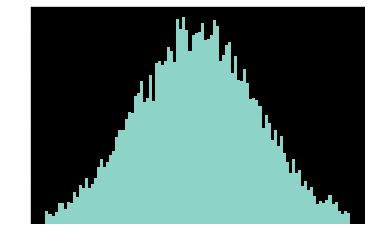

In [4]:
# Plot a histogram over the actual test scores
plt.hist(pop_resample.scores, 100, density=True);
# the population's scores are stored in the 'scores' attribute

We can translate this distribution into the four data points in the Dunning-Kruger graph by splitting the scores into quarts and calculating the mean score for each quart

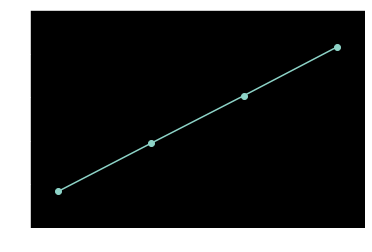

[0.16708761718261542, 0.38865518292167056, 0.6081070519575721, 0.8316019496568989]


In [5]:
plt.scatter(range(len(pop_resample.quart_scores)), pop_resample.quart_scores)
plt.plot(pop_resample.quart_scores)
# the mean score for each quart is stored in the populations 'quart_scores' attribute
plt.axis([-0.3, 3.3, 0.0, 1.0])
plt.show()
# we also print the actual numbers:
print(pop_resample.quart_scores)

This data is read in the following way: the persons belonging to the bottom quart (point at `x=0.0`) score on an avarage the value read on the y-axis (first number printed below the graph).

### 2. Generate errors

Again we use a normal distribution to generate error-value. These "errors" are the values added to the actual scores, and represents the deviation in a persons predicted score from the actual score. The normal has no bias, that is no mean. As a default we use:

$$\mathcal{N}(\mu: 0.5,\ \ \sigma: 0.2)$$

This means that people would have estimated their scores to be (yellow graph):

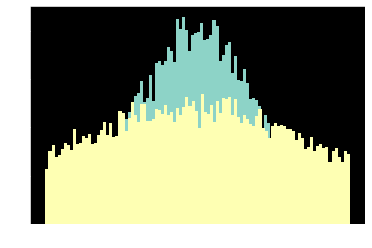

In [6]:
plt.hist(pop_resample.scores, 100, density=True);
# errors are stored in the attribute 'errors', which then are added to the 'scores' to produce the guesses
plt.hist(pop_resample.scores + pop_resample.errors, 100, density=True);
plt.show()

The distribution is now much flatter. Notice that the distribution is bound. This is because we again resample the error if it goes beyond the test score bounds. That is, people scoring `100%` will probably not be given the chance to estimate that they will get a `104%` score, nor will the people scoring `0%` predict that they get `-2%` result.

### 3. Scores per quart

To get the second set of data points for the DK graph, we need to keep track of the actual scores, which quart the persons belong to, and then update the mean with the score with the error added. That is, the bottom quart means people actually scoring in the bottom, not people guessing they will end up in the bottom. If we do this we get the following

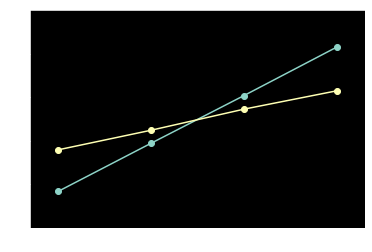

Persons in the bottom quant scored 0.19132840687032346 points worse than their guess.
Persons in the second quant scored 0.05996940689945324 points worse than their guess.
Persons in the third quant scored 0.06248406838747422 points better than their guess.
Persons in the top quant scored 0.20137380478813982 points better than their guess.


In [7]:
plt.scatter(range(len(pop_resample.quart_scores)), pop_resample.quart_scores)
plt.plot(pop_resample.quart_scores)
plt.scatter(range(len(pop_resample.quart_estimates)), pop_resample.quart_estimates)
plt.plot(pop_resample.quart_estimates)
plt.axis([-0.3, 3.3, 0.0, 1.0])
plt.show()
s = np.array(pop_resample.quart_scores) - np.array(pop_resample.quart_estimates)
for i in range(4):
    print("Persons in the ", end="")
    print({
        0: "bottom",
        1: "second",
        2: "third",
        3: "top"
    }[i], end="")
    print(" quant scored ", end="")
    if s[i] < 0:
        print(f"{-s[i]} points worse than their guess.")
    else:
        print(f"{s[i]} points better than their guess.")

### 4. Comparing to DK

Then we compare this to estimating the data from the DK-graph

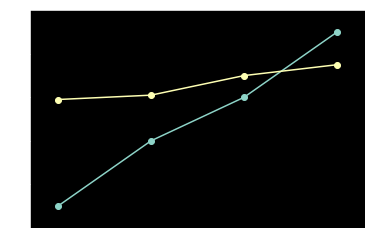

Persons in the bottom quant scored 0.49 points worse than their guess.
Persons in the second quant scored 0.20999999999999996 points worse than their guess.
Persons in the third quant scored 0.09999999999999998 points worse than their guess.
Persons in the top quant scored 0.15000000000000002 points better than their guess.


In [8]:
# Numbers estimated from the DK-graph by eye
dk_estimates = [.59, .61, .70, .75]
dk_actual = [.1, .4, .6, .9]

plt.scatter(range(len(dk_actual)), dk_actual)
plt.plot(dk_actual)
plt.scatter(range(len(dk_estimates)), dk_estimates)
plt.plot(dk_estimates)
plt.axis([-0.3, 3.3, 0.0, 1.0])
plt.show()

s = np.array(dk_actual) - np.array(dk_estimates)
for i in range(4):
    print("Persons in the ", end="")
    print({
        0: "bottom",
        1: "second",
        2: "third",
        3: "top"
    }[i], end="")
    print(" quant scored ", end="")
    if s[i] < 0:
        print(f"{-s[i]} points worse than their guess.")
    else:
        print(f"{s[i]} points better than their guess.")

we see the same sort of behaviour: The bottom scores worse than their guesses (overestimates their potential), while the top scores better than their guesses (underestimates their potential), with significant numbers.

There is still a bias in the DK graph, bottom quants of the yellow graph are still very high, but we will get to that.

### 5. Where does this behaviour come from?

In this case, it is the resampling. We we turn it off, and instead just let people estimate their score with a non-resampled error we instead get the following distributions:

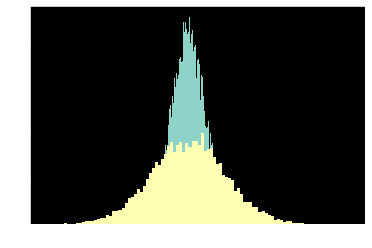

In [9]:
pop_trunc = Pop(resample=False)
plt.hist(pop_trunc.scores, 100, density=True);
plt.hist(pop_trunc.scores + pop_trunc.errors, 100, density=True);
plt.show()

Peoples guesses are now completely unbiased by the bound. Everyone are free to guess beyond the confines of the possible test score results. Do the bottom overestimate themselves now?

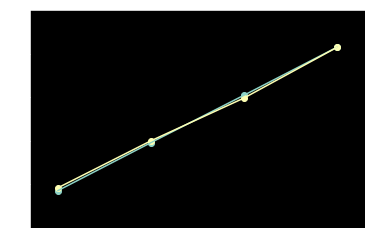

Persons in the bottom quant scored 0.012969881239564274 points worse than their guess.
Persons in the second quant scored 0.008507728482108734 points worse than their guess.
Persons in the third quant scored 0.013000405976300256 points better than their guess.
Persons in the top quant scored 0.000533195004446041 points better than their guess.


In [10]:
plt.scatter(range(len(pop_trunc.quart_scores)), pop_trunc.quart_scores)
plt.plot(pop_trunc.quart_scores)
plt.scatter(range(len(pop_trunc.quart_estimates)), pop_trunc.quart_estimates)
plt.plot(pop_trunc.quart_estimates)
plt.axis([-0.3, 3.3, 0.0, 1.0])
plt.show()
s = np.array(pop_trunc.quart_scores) - np.array(pop_trunc.quart_estimates)
for i in range(4):
    print("Persons in the ", end="")
    print({
        0: "bottom",
        1: "second",
        2: "third",
        3: "top"
    }[i], end="")
    print(" quant scored ", end="")
    if s[i] < 0:
        print(f"{-s[i]} points worse than their guess.")
    else:
        print(f"{s[i]} points better than their guess.")

The bottom quart does not overestimate themselves in a consistent nor significant way. And that should be no surprise, it is just random.

The feature appears due to the bounds of the test. In the two extremes it is obvious:

 * A person that will score `0%` will guess their score will be `0%` or higher. Because those are the only possble choices!
 * A person that will score `100%` will guess their score will be `100%` or lower. For the same reason!
 
Around the edges, peoples guesses are naturally pushed into the middle. Not because of a human bias, but because that is how this statistics problem works.

### 5. What about that last bias in the DK-graph?

Lets also play around with a "mean" and a "bias".

The "mean" is the bias for anyone to overestimate themselves, a `0.0` mean has no such bias, and for `0.5` it would mean that on avarage a person would expect to have `50` points higher score than they actually would have.

The "bias" instead is how much the error of the error (the $\sigma$ of the normal distribution usedto generate errors that are added to the actual score) scales with actual score. That is, someone scoring in the top would probably be better at guessing their actual score than someone in the bottom.

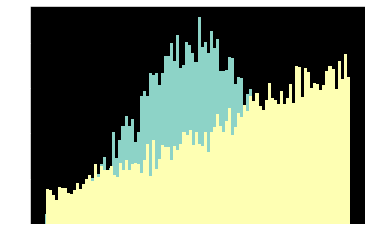

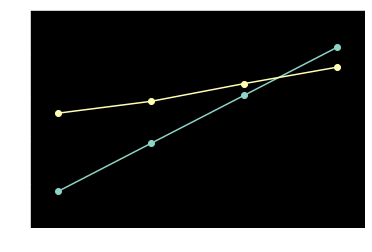

Persons in the bottom quant scored 0.35977478030058657 points worse than their guess.
Persons in the second quant scored 0.19309803396933806 points worse than their guess.
Persons in the third quant scored 0.05418097164655866 points worse than their guess.
Persons in the top quant scored 0.09132680133653293 points better than their guess.


In [11]:
pop_bias = Pop(bias=0.3, mean=0.5)
plt.hist(pop_bias.scores, 100, density=True);
plt.hist(pop_bias.scores + pop_bias.errors, 100, density=True);
plt.show()
plt.scatter(range(len(pop_bias.quart_scores)), pop_bias.quart_scores)
plt.plot(pop_bias.quart_scores)
plt.scatter(range(len(pop_bias.quart_estimates)), pop_bias.quart_estimates)
plt.plot(pop_bias.quart_estimates)
plt.axis([-0.3, 3.3, 0.0, 1.0])
plt.show()
s = np.array(pop_bias.quart_scores) - np.array(pop_bias.quart_estimates)
for i in range(4):
    print("Persons in the ", end="")
    print({
        0: "bottom",
        1: "second",
        2: "third",
        3: "top"
    }[i], end="")
    print(" quant scored ", end="")
    if s[i] < 0:
        print(f"{-s[i]} points worse than their guess.")
    else:
        print(f"{s[i]} points better than their guess.")

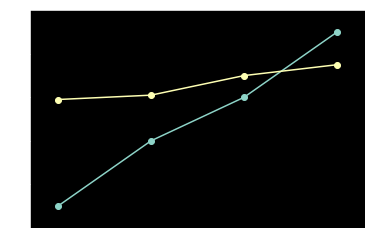

In [12]:
# DK-graph again for easy comparison
plt.scatter(range(len(dk_actual)), dk_actual)
plt.plot(dk_actual)
plt.scatter(range(len(dk_estimates)), dk_estimates)
plt.plot(dk_estimates)
plt.axis([-0.3, 3.3, 0.0, 1.0])
plt.show()

one can play around with the "mean" and "bias" a bit, and one can approximate the DK graph quite well.

If this would hold agains more actual data, that would mean that the DK effect is not actually a measure of people over- or underestimating their knowledge in a subject. Rather that people generally overestimates themselves (if "mean" turns out to be significant) and that being unknowledgable in a field means that you have a harder time to gauge your actual comprehension of that field (if "bias" turns out to be significant).